# Optimal binning и кредитный скоринг

## Обзор возможностей библиотеки OptBinning

In [83]:
pip install optbinning

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer

In [85]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Дискретизируем mean radius

In [86]:
variable_discretize = "mean radius"
x = df[variable_discretize].values
y = data.target

In [87]:
from optbinning import OptimalBinning
optb = OptimalBinning(name=variable_discretize, dtype="numerical", solver="cp")

In [88]:
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 11.43)",118,0.207381,3,115,0.974576,-3.12517,0.962483,0.087205
1,"[11.43, 12.33)",79,0.138840,3,76,0.962025,-2.71097,0.538763,0.052198
2,"[12.33, 13.09)",68,0.119508,7,61,0.897059,-1.64381,0.226599,0.025513
3,"[13.09, 13.70)",49,0.086116,10,39,0.795918,-0.839827,0.052131,0.006331
4,"[13.70, 15.05)",83,0.145870,28,55,0.662651,-0.153979,0.003385,0.000423
5,"[15.05, 16.93)",54,0.094903,44,10,0.185185,2.00275,0.359566,0.038678
6,"[16.93, inf)",118,0.207381,117,1,0.008475,5.28332,2.900997,0.183436
7,Special,0,0.000000,0,0,0.000000,0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0,0.000000,0.000000
Totals,,569,1.000000,212,357,0.627417,,5.043925,0.393784


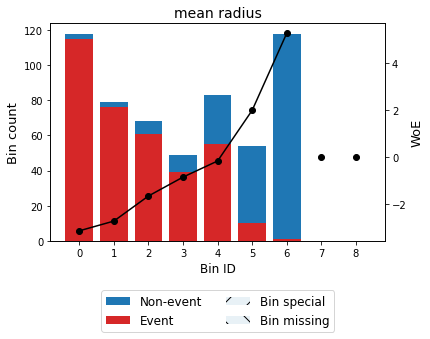

In [13]:
optb.binning_table.plot(metric="woe")

## Кредитный скоринг с помощью биннинга, небольшой датасет

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


В этом датасете нет описания данных, 6 количественных, 9 категориальных переменных

In [95]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/opt_binning/crx.data', header=None, decimal=".")
df.columns = ['A' + str(i) for i in range(1, 16)] + ['target']

target = 'target'

df = df.replace(to_replace='?',value=np.nan)
df = df.replace(to_replace="+", value=1)
df = df.replace(to_replace="-", value=0)
df.fillna(df.mean(), inplace=True)

df['A2'] = pd.to_numeric(df['A2'], errors='coerce')
df['A2'] = df['A2'].replace(to_replace=np.nan, value=0, regex=True)
df['A14'] = df['A14'].apply(lambda val: str(val).lstrip("0"))
df['A14'] = pd.to_numeric(df['A14'], errors='coerce')
df['A14'] = df['A14'].replace(to_replace=np.nan, value=0, regex=True)

for col in df.columns:
    if df[col].dtypes == 'object':
        df = df.fillna(df[col].value_counts().index[0])

categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object' and c != 'target']
columns = df.columns.drop('target').tolist()

X = df.drop('target', axis=1)
y = df['target']

print(categorical_columns)
print(numerical_columns)
print(columns)

['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']
['A2', 'A3', 'A8', 'A11', 'A14', 'A15']
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15']


In [96]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,1


In [97]:
from optbinning import BinningProcess, Scorecard
from sklearn.linear_model import LogisticRegression

selection_criteria = {
    "iv": {"min": 0.02, "max": 1},
    "quality_score": {"min": 0.01}
}

binning_process = BinningProcess(columns, 
                                 categorical_variables=categorical_columns,
                                 selection_criteria=selection_criteria)


estimator = LogisticRegression(solver="lbfgs")

scorecard = Scorecard(target=target, binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [108]:
df_train = pd.DataFrame(data=X_train)
df_train['target'] = y_train
df_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
647,b,24.08,9.00,u,g,aa,v,0.250,f,f,0,t,g,0.0,0,0
163,b,32.00,1.75,y,p,e,h,0.040,t,f,0,t,g,393.0,0,1
380,b,43.17,5.00,u,g,i,bb,2.250,f,f,0,t,g,141.0,0,0
603,b,20.08,0.25,u,g,q,v,0.125,f,f,0,f,g,200.0,0,0
432,b,21.83,1.54,u,g,k,v,0.085,f,f,0,t,g,356.0,0,0


In [109]:
scorecard.fit(df_train)

Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                         binning_transform_params=None,
                                         categorical_variables=['A1', 'A4',
                                                                'A5', 'A6',
                                                                'A7', 'A9',
                                                                'A10', 'A12',
                                                                'A13'],
                                         max_bin_size=None, max_n_bins=None,
                                         max_n_prebins=20, max_pvalue=None,
                                         max_pvalue_policy='consecutive',
                                         min_bin_size=None, min_n_bins=None,
                                         min_prebin_size=0.05, n_jobs=None,
                                         selection_criteri...
          estimator=LogisticRegression(C=1

In [110]:
scorecard.information(print_level=2)

optbinning (Version 0.9.1)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    target                            target   * U
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    517
    Number of variables                   15
    Target type                       binary

    Number of numerical                    6
    Number of categorical                  9
    Number of selected                     9

  Timing
    Total time                          0.97 sec
    Binning process                     0.91 sec   ( 93.71%)
    Estim

In [111]:
scorecard.table(style="summary")

,Variable,Bin,Points
0,A2,"[-inf, 18.71)",88.224800
1,A2,"[18.71, 22.54)",66.270351
2,A2,"[22.54, 36.62)",56.884993
3,A2,"[36.62, 40.96)",49.329104
4,A2,"[40.96, 55.83)",38.709156
5,A2,"[55.83, inf)",16.887566
6,A2,Special,55.665462
7,A2,Missing,55.665462
0,A3,"[-inf, 0.21)",45.877636
1,A3,"[0.21, 0.52)",62.848672


In [112]:
df_test = pd.DataFrame(data=X_test)
df_test['target'] = y_test
y_pred = scorecard.predict_proba(df_test)[:, 1]

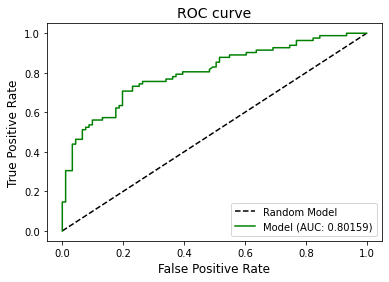

In [113]:
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
plot_auc_roc(df_test[target], y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


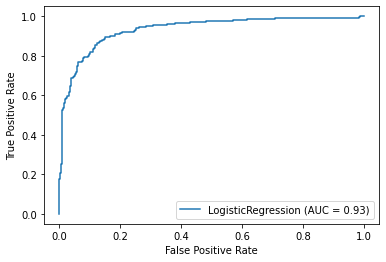

In [116]:
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler

base_model = LogisticRegression()
df_dummies = df
df_dummies = pd.get_dummies(df_dummies, columns=['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13'], drop_first=True)

X_d = df_dummies.drop('target', axis=1)
y_d = df_dummies['target']

base_model.fit(X_d, y_d)

plot_roc_curve(base_model, X_d, y_d)

In [117]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.25, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


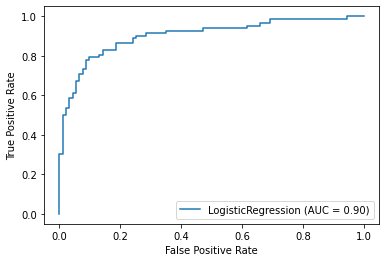

In [118]:
base_model.fit(X_train_d, y_train_d)

plot_roc_curve(base_model, X_test_d, y_test_d)

Может, было много категориальных переменных?...

## Кредитный скоринг на датасете Credit Risk Dataset

[dataset](https://www.kaggle.com/laotse/credit-risk-dataset?select=credit_risk_dataset.csv)

In [120]:
credit_risk = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/opt_binning/credit_risk_dataset.csv")
credit_risk.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [121]:
target = "loan_status"
categorical_cols = [c for c in credit_risk.columns if credit_risk[c].dtype.name == 'object']
numeric_cols = [c for c in credit_risk.columns if credit_risk[c].dtype.name != 'object' and c != target]
cols = [c for c in credit_risk.columns if c != target]

print(categorical_cols)
print(numeric_cols)

X = credit_risk.drop(target, axis=1)
y = credit_risk[target]

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


In [122]:
credit_risk.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [123]:
credit_risk.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [124]:
credit_risk["person_emp_length"].fillna(credit_risk["person_emp_length"].mean(), inplace=True)
credit_risk["loan_int_rate"].fillna(credit_risk["loan_int_rate"].mean(), inplace=True)

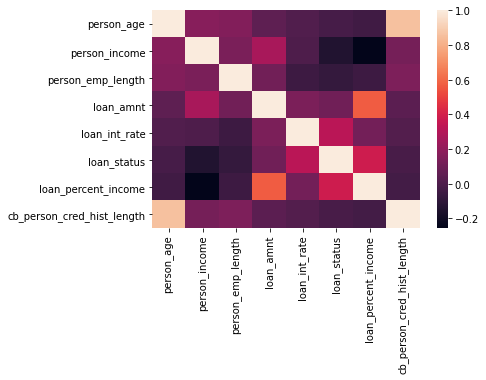

In [133]:
corr = credit_risk.corr()
sns.heatmap(corr)

In [125]:
selection_criteria = {
    "iv": {"min": 0.02, "max": 1},
    "quality_score": {"min": 0.01}
}

binning_process = BinningProcess(cols, 
                                 categorical_variables=categorical_cols,
                                 selection_criteria=selection_criteria)


estimator = LogisticRegression(solver="lbfgs")

scorecard = Scorecard(target=target, binning_process=binning_process,
                      estimator=estimator,
                      scaling_method="min_max", scaling_method_params={"min" : 400, "max": 800})

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

credit_risk_train = pd.DataFrame(data=X_train)
credit_risk_train[target] = y_train

credit_risk_test = pd.DataFrame(data=X_test)
credit_risk_test[target] = y_test

scorecard.fit(credit_risk_train)

Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                         binning_transform_params=None,
                                         categorical_variables=['person_home_ownership',
                                                                'loan_intent',
                                                                'loan_grade',
                                                                'cb_person_default_on_file'],
                                         max_bin_size=None, max_n_bins=None,
                                         max_n_prebins=20, max_pvalue=None,
                                         max_pvalue_policy='consecutive',
                                         min_bin_size=None, min_n_bins=None,
                                         min_prebin_size=0.0...
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                       fit_intercept=True, intercept_scaling=

In [127]:
scorecard.information(print_level=2)

optbinning (Version 0.9.1)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    target                       loan_status   * U
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                  24435
    Number of variables                   11
    Target type                       binary

    Number of numerical                    7
    Number of categorical                  4
    Number of selected                     9

  Timing
    Total time                          1.14 sec
    Binning process                     0.95 sec   ( 83.20%)
    Estim

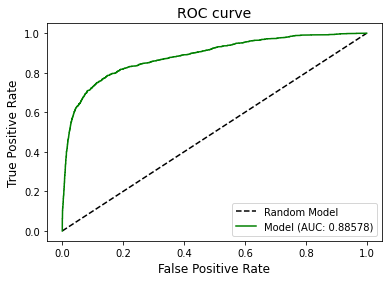

In [128]:
y_pred = scorecard.predict_proba(credit_risk_test)[:, 1]
plot_auc_roc(credit_risk_test[target], y_pred)

In [136]:
scorecard.table(style="summary")[:]

,Variable,Bin,Points
0,person_income,"[-inf, 22840.00)",20.758327
1,person_income,"[22840.00, 34935.00)",48.297321
2,person_income,"[34935.00, 39937.50)",64.155223
3,person_income,"[39937.50, 49986.00)",70.904317
4,person_income,"[49986.00, 59846.50)",72.208379
...,...,...,...
11,loan_percent_income,Missing,70.634334
0,cb_person_default_on_file,[N],70.283435
1,cb_person_default_on_file,[Y],71.933190
2,cb_person_default_on_file,Special,70.634334


In [129]:
table = scorecard.table(style="detailed")
table[table["Variable"] == "loan_int_rate"]

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,loan_int_rate,0,"[-inf, 6.10)",1332,0.054512,1248,84,0.063063,1.412981,0.069698,0.008053,-0.105153,75.311713
1,loan_int_rate,1,"[6.10, 7.21)",1725,0.070595,1559,166,0.096232,0.954312,0.047794,0.005757,-0.105153,73.793386
2,loan_int_rate,2,"[7.21, 7.89)",2338,0.095682,2102,236,0.100941,0.901313,0.058787,0.007109,-0.105153,73.617943
3,loan_int_rate,3,"[7.89, 9.64)",2421,0.099079,2106,315,0.130112,0.614473,0.031035,0.003820,-0.105153,72.668420
4,loan_int_rate,4,"[9.64, 11.13)",3783,0.154819,3172,611,0.161512,0.361521,0.018175,0.002260,-0.105153,71.831074
5,loan_int_rate,5,"[11.13, 12.14)",2213,0.090567,1829,384,0.173520,0.275382,0.006334,0.000789,-0.105153,71.545930
6,loan_int_rate,6,"[12.14, 13.09)",2132,0.087252,1729,403,0.189024,0.170862,0.002424,0.000303,-0.105153,71.199938
7,loan_int_rate,7,"[13.09, 13.61)",1418,0.058032,1098,320,0.225670,-0.052575,0.000163,0.000020,-0.105153,70.460295
8,loan_int_rate,8,"[13.61, 14.37)",1238,0.050665,882,356,0.287561,-0.378238,0.008012,0.000996,-0.105153,69.382255
9,loan_int_rate,9,"[14.37, 15.28)",1318,0.053939,717,601,0.455994,-1.109019,0.084384,0.010039,-0.105153,66.963159


In [130]:
table[table["Variable"] == "person_income"]

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,person_income,0,"[-inf, 22840.00)",1223,0.050051,455,768,0.627964,-1.808992,0.219481,0.024216,-0.875809,20.758327
1,person_income,1,"[22840.00, 34935.00)",3412,0.139636,2104,1308,0.383353,-0.810159,0.111157,0.013527,-0.875809,48.297321
2,person_income,2,"[34935.00, 39937.50)",1698,0.069490,1258,440,0.259128,-0.234996,0.004091,0.000510,-0.875809,64.155223
3,person_income,3,"[39937.50, 49986.00)",3610,0.147739,2834,776,0.214958,0.009792,0.000014,0.000002,-0.875809,70.904317
4,person_income,4,"[49986.00, 59846.50)",3303,0.135175,2619,684,0.207084,0.057090,0.000433,0.000054,-0.875809,72.208379
5,person_income,5,"[59846.50, 79942.50)",5102,0.208799,4312,790,0.154841,0.411624,0.031288,0.003884,-0.875809,81.983299
6,person_income,6,"[79942.50, 89325.00)",1459,0.059709,1317,142,0.097327,0.941785,0.039530,0.004766,-0.875809,96.600438
7,person_income,7,"[89325.00, inf)",4628,0.189400,4243,385,0.083189,1.114283,0.165941,0.019732,-0.875809,101.356404
8,person_income,8,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.875809,70.634334
9,person_income,9,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.875809,70.634334


In [132]:
base_model = LogisticRegression(solver='liblinear')

X_dum_scaled = X.copy()
features = X_dum_scaled[numeric_cols]
scalerRisk = StandardScaler().fit(features.values)
features = scalerRisk.transform(features.values)

X_dum_scaled[numeric_cols] = features

X_dum_scaled.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,-0.903374,-0.114143,RENT,28.535538,PERSONAL,D,4.019404,1.545580,3.931411,Y,-0.691554
1,-1.060904,-0.911147,OWN,0.050769,EDUCATION,B,-1.358650,0.039595,-0.657458,N,-0.938167
2,-0.430783,-0.911147,MORTGAGE,-0.914816,MEDICAL,C,-0.646849,0.573479,3.744110,N,-0.691554
3,-0.745843,-0.009274,RENT,-0.190627,MEDICAL,C,4.019404,1.301784,3.369508,N,-0.938167
4,-0.588313,-0.188358,RENT,0.774958,MEDICAL,C,4.019404,1.005524,3.556809,Y,-0.444942


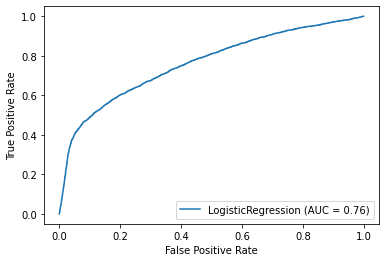

In [40]:
X_dum = pd.get_dummies(X, columns=categorical_cols)

base_model.fit(X_dum, y)

plot_roc_curve(base_model, X_dum, y)

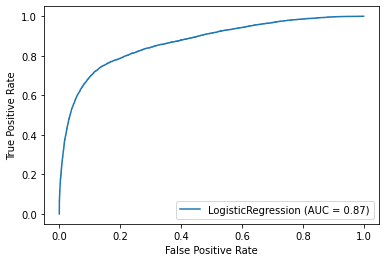

In [42]:
X_dum_scaled = pd.get_dummies(X_dum_scaled, columns=categorical_cols)

base_model.fit(X_dum_scaled, y)

plot_roc_curve(base_model, X_dum_scaled, y)

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

In [79]:
binning_fit_params = {
    "person_income" : {"monotonic_trend" : "ascending"},
    "person_age" : {"monotonic_trend" : "peak"}
}

binning_process = BinningProcess(cols, 
                                 categorical_variables=categorical_cols,
                                 selection_criteria=selection_criteria,
                                 binning_fit_params=binning_fit_params)


estimator = LogisticRegression(solver="lbfgs")

scorecard = Scorecard(target=target, binning_process=binning_process,
                      estimator=estimator,
                      scaling_method="min_max", scaling_method_params={"min" : 400, "max": 800})

In [80]:
scorecard.fit(credit_risk)

Scorecard(binning_process=BinningProcess(binning_fit_params={'person_age': {'monotonic_trend': 'peak'},
                                                             'person_income': {'monotonic_trend': 'ascending'}},
                                         binning_transform_params=None,
                                         categorical_variables=['person_home_ownership',
                                                                'loan_intent',
                                                                'loan_grade',
                                                                'cb_person_default_on_file'],
                                         max_bin_size=None, max_n_bins=None,
                                         max_n_prebins=20, max_pvalue=None,...
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                       fit_intercept=True, intercept_scaling=1,
                                       l1_ratio=None, max_

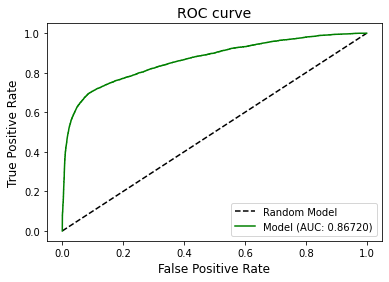

In [81]:
y_pred = scorecard.predict_proba(credit_risk)[:, 1]
plot_auc_roc(credit_risk[target], y_pred)